In [62]:
# Handle all includes
%load_ext autoreload
%autoreload 2

import os
import shutil
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from spatz.utils.preprocess import preprocess_file
from spatz.simulation import Simulation, UniformTimeSteps


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
# Do preprocessing
PATH = "data/simulations"
TMP = f"{PATH}/temp"
FILE = "28km"

if os.path.isdir(TMP):
    shutil.rmtree(TMP)
os.mkdir(TMP)

df = preprocess_file(f"{PATH}/{FILE}.txt")
df.to_csv(f"{TMP}/{FILE}.csv")


In [64]:
# Create simulation objects
timesteps = UniformTimeSteps(0.1, mu=0, sigma=0, delay_only=True)
simulation = Simulation(timesteps)

In [65]:
from spatz.sensors.antenna.pathloss import AntennaPathloss
from spatz.sensors.antenna.tx_gain import AntennaTxGain
from spatz.sensors.antenna.constants import STAHR_LORA_FREQ, STAHR_GS_OFFSET

alt = simulation.add_observer(['altitude'])
fspl_gs = simulation.add_sensor(AntennaPathloss,frequency=STAHR_LORA_FREQ,rx_antenna_offset=STAHR_GS_OFFSET)

tx_gain = simulation.add_sensor(AntennaTxGain,gain_pattern_path=f"data/gain_pattern/farfield_tx_aisler_v1.txt",rx_antenna_offset = STAHR_GS_OFFSET)

simulation.load(f"{TMP}/{FILE}.csv")
logger = simulation.get_logger()

Processed 65160 lines in 0.3s.
Used 65160 lines due to step size


In [66]:
# Run simulation
for step, t, dt in simulation.run(verbose=True):
    fspl_gs()
    tx_gain()
    alt()

df = logger.get_dataframe()

100%|█████████▉| 639.1000000000768/639.150194412893 [00:26<00:00, 23.94it/s] 


In [67]:
df

time antenna/pathloss/distance antenna/pathloss/out  \
0       0.1               2393.667868           107.812383   
1       0.2               2393.715998           107.812557   
2       0.3               2393.765548           107.812737   
3       0.4               2393.816519           107.812922   
4       0.5               2393.868912           107.813112   
...     ...                       ...                  ...   
6386  638.7              25768.750389           128.452972   
6387  638.8              25770.724327           128.453637   
6388  638.9               25772.69835           128.454303   
6389  639.0              25774.672457           128.454968   
6390  639.1               25776.64665           128.455633   

     antenna/tx_gain/rocket_x antenna/tx_gain/rocket_y  \
0                        -0.0                 0.171335   
1                        -0.0                 0.171335   
2                        -0.0                 0.171335   
3                        -0.0                 0.171335   
4                        -0.0                 0.171335   
...                       ...                      ...   
6386                -0.019599                -0.005745   
6387                -0.021452                -0.000441   
6388                -0.021841                 0.005372   
6389                 -0.02063                 0.011282   
6390                -0.017799                 0.016842   

     antenna/tx_gain/rocket_z antenna/tx_gain/pos_x antenna/tx_gain/pos_y  \
0                    0.985213              0.774005              0.626653   
1                    0.985213              0.773925              0.626641   
2                    0.985213              0.773845              0.626628   
3                    0.985213              0.773764              0.626614   
4                    0.985213              0.773683              0.626601   
...                       ...                   ...                   ...   
6386                 0.999791             -0.976774              0.108145   
6387                  0.99977             -0.976763              0.108148   
6388                 0.999747             -0.976752               0.10815   
6389                 0.999724             -0.976741              0.108153   
6390                   0.9997              -0.97673              0.108156   

     antenna/tx_gain/pos_z antenna/tx_gain/theta antenna/tx_gain/out  \
0                 0.090671            101.343943            4.212357   
1                 0.091437            101.387942            4.208309   
2                 0.092204            101.431938            4.204262   
3                  0.09297            101.475932            4.200214   
4                 0.093736            101.519925            4.196167   
...                    ...                   ...                 ...   
6386             -0.184981             80.420236            4.913187   
6387             -0.185037             80.555707            4.917116   
6388             -0.185094             80.611251            4.918726   
6389              -0.18515             80.576614            4.917722   
6390             -0.185206             80.447889            4.913989   

     general/altitude  
0          319.625548  
1          320.876645  
2          322.127741  
3          323.378837  
4          324.629934  
...               ...  
6386          2.63791  
6387          2.04426  
6388          1.45061  
6389         0.856961  
6390         0.263311  

[6391 rows x 12 columns]

130.43368058102035


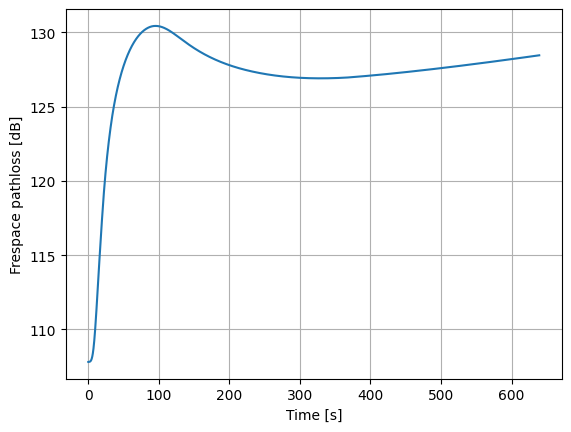

In [68]:
plt.grid()
plt.plot(df['time'][1:], df['antenna/pathloss/out'][1:], label='FSPL')
plt.ylabel("Frespace pathloss [dB]")
plt.xlabel("Time [s]")

print(np.max(df['antenna/pathloss/out'][1:]))

32368.96280616025


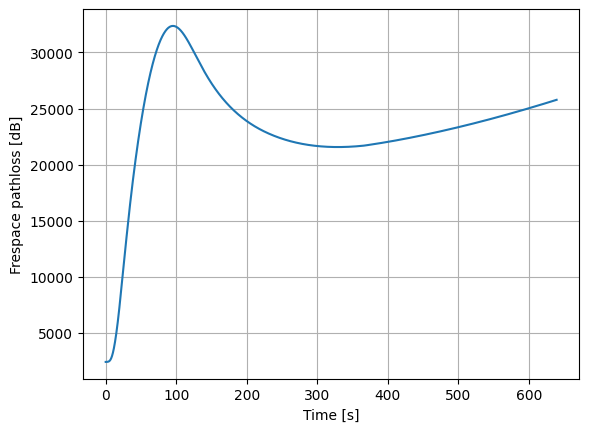

In [69]:
plt.grid()
plt.plot(df['time'][1:], df['antenna/pathloss/distance'][1:], label='Dist to GS')
plt.ylabel("Frespace pathloss [dB]")
plt.xlabel("Time [s]")

print(np.max(df['antenna/pathloss/distance'][1:]))

-7.360621740783089


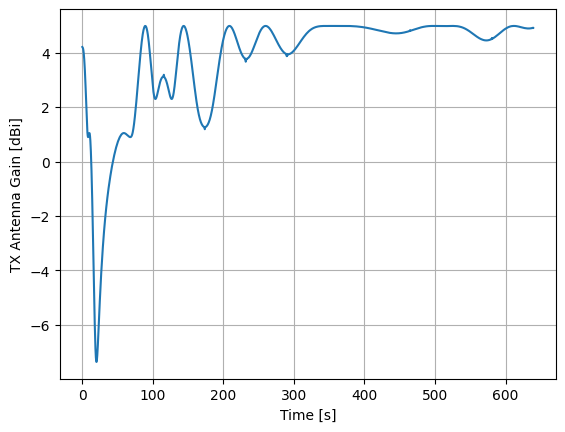

In [70]:
plt.grid()
plt.plot(df['time'][1:], df['antenna/tx_gain/out'][1:], label='FSPL')
plt.ylabel("TX Antenna Gain [dBi]")
plt.xlabel("Time [s]")

print(np.min(df['antenna/tx_gain/out'][1:]))

-107.75182721480577


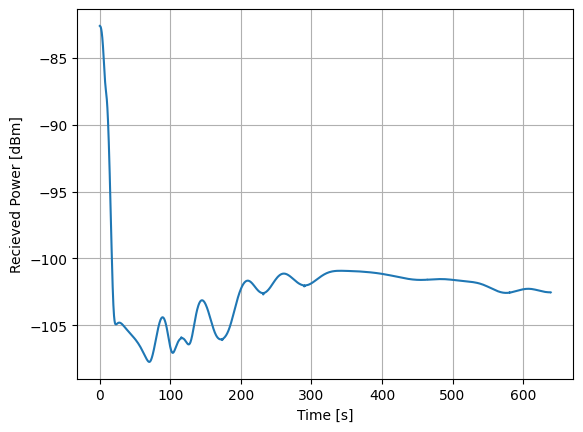

In [71]:
# Calculate recieved power
# Assumptions:  3 dB polarization loss
#               25 dBm output power per channel
#               16 dBi antenna rx gain
#               -6 dB on reciever side


df["antenna/power_rx"] = 20+df["antenna/tx_gain/out"] - df["antenna/pathloss/out"] - 3 + 10 - 6 
plt.grid()
plt.plot(df['time'][1:], df['antenna/power_rx'][1:], label='FSPL')
plt.ylabel("Recieved Power [dBm]")
plt.xlabel("Time [s]")

print(np.min(df['antenna/power_rx'][1:]))